In [1]:
# region General Imports
import os
import re
import uuid
import shutil
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain
from functools import partial
# endregion General Imports

import tempfile
import tensorflow as tf
import numpy as np
from tensorflow import keras

import tensorflow_model_optimization as tfmot
%load_ext tensorboard
    
# os.environ["KERAS_BACKEND"] = "tf"
# os.environ["TF_USE_LEGACY_KERAS"] = "0"
# import jax
# import jax.numpy as jnp
# import keras
    
# region Keras
from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Conv1D,
    MaxPooling1D,
    AveragePooling1D,
)
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.regularizers import l1_l2
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K
# endregion Keras

from custom_datasets.fatigue_mi import FatigueMI

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from sklearn import preprocessing

from model_optim.utils import channels_to_channels_idx

2024-04-20 01:20:10.870197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 01:20:10.870247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 01:20:10.873859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 01:20:10.901380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 01:20:12.632025: W tensorflow/compiler/tf2

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/home/arazzz/anaconda3/envs/moabb_model_optimization_quant/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
SKLRNG = 42
# RNG = jax.random.PRNGKey(SKLRNG)

In [3]:
# region Helper funcs
def shallow_conv_net_square_layer(x):
    return tf.math.square(x)

def shallow_conv_net_log_layer(x):
    return tf.math.log(tf.clip_by_value(x, 1e-7, 10000))

CUSTOM_OBJECTS = {
    "shallow_conv_net_square_layer": shallow_conv_net_square_layer, 
    "shallow_conv_net_log_layer": shallow_conv_net_log_layer 
}
# endregion Helper funcs


In [4]:
best_models_df = pd.read_csv("./final/best_models.csv").drop(columns=["Unnamed: 0"])

best_models_df.head(5)

,trial_number,train_acc,test_acc,val_acc,train_val_acc_diff,train_loss,val_loss,train_val_loss_diff,test_loss,scores,channels_selected,sfreq,batch_size,model_name,subjects,file_path
0,1,0.779412,0.681818,0.777778,0.001634,0.451416,0.575806,0.124390,0.658583,0.299783,['P3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O2' 'T6'],256.0,32.0,deep_conv_net,11,./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb...
1,3,0.970588,0.681818,0.722222,0.248366,0.755424,1.030562,0.275138,1.222213,0.077861,['P3' 'C3' 'F3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O1' ...,256.0,256.0,eeg_net,11,./temp/FatigueMI/[11]/6772e2405e6e436faba83820...
2,0,0.941176,0.727273,0.666667,0.274510,0.501189,0.778463,0.277274,0.757358,0.853020,['P3' 'C3' 'Fz' 'F4' 'C4' 'P4' 'F7' 'F8'],NaN,NaN,shallow_conv_net,11,./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd...
3,23,0.852941,0.727273,0.888889,0.035948,0.388678,0.429204,0.040526,0.646307,0.262646,['C3' 'F3' 'C4' 'Cz' 'Fp2' 'T6'],128.0,128.0,deep_conv_net,12,./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e407...
4,15,0.955882,0.818182,0.833333,0.122549,0.432221,0.737542,0.305321,0.739283,0.028128,['P3' 'C3' 'F3' 'C4' 'Cz' 'Pz' 'Fp2'],128.0,32.0,eeg_net,12,./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d...


In [5]:
subject_best_file_paths = best_models_df[['file_path']].to_numpy().flatten().tolist()
subject_best_trial_numbers = best_models_df[['trial_number']].to_numpy().flatten().tolist()
subject_best_trials = list(zip(subject_best_file_paths, subject_best_trial_numbers))
rpprint(subject_best_trials)

[
│   ('./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb93fd4f9a/model/deep_conv_net_study.npy', 1),
│   ('./temp/FatigueMI/[11]/6772e2405e6e436faba8382021d362e4/model/eeg_net_study.npy', 3),
│   ('./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e4071f15f07a/model/deep_conv_net_study.npy', 23),
│   ('./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d120893ed/model/eeg_net_study.npy', 15),
│   ('./temp/FatigueMI/[12]/96dc576945fb4f2db582d66ae1d2c8ce/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[4]/52166a0614d541acb9b9ef965eed5de2/model/deep_conv_net_study.npy', 19),
│   ('./temp/FatigueMI/[4]/72578c4a27b64a8e989fd90727f209ad/model/eeg_net_study.npy', 11),
│   ('./temp/FatigueMI/[4]/3623cb4ba1ad4a908c9098f5297a6778/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[6]/0614f3b1603b4442a2cc79ade04a6a0d/model/deep_conv_net_study.npy', 2),
│   ('./temp/FatigueMI/[6]/969f098d0f9344e5baa14cc429e2471b/model/eeg_net_study.npy', 10),
│   ('./temp/FatigueMI/[6]/7ec6d62fc9a84597a65261efcb6e808a/model/shallow_conv_net_study.npy', 5),
│   ('./temp/FatigueMI/[9]/0113b240ca004b67b81ca0fd5df6dd6e/model/deep_conv_net_study.npy', 13),
│   ('./temp/FatigueMI/[9]/fd4945e8633f4c0ab473e7520efcfee6/model/eeg_net_study.npy', 19),
│   ('./temp/FatigueMI/[9]/63a8c87ffc02471893db5ac9a0781946/model/shallow_conv_net_study_best_trial.npy', 0)
]

In [7]:
# subject_best_trials = glob.glob('./temp_v2/**/model/shallow_conv_net_study_best_trial.npy', recursive=True)
# subject_best_trials = sorted(subject_best_trials, key=lambda x: os.path.getmtime(x))
# subject_best_trials = sorted(subject_best_trials, key=lambda x: int(re.compile(r"\[.*\]").search(x).group(0).strip("[]")))

In [8]:
def data_generator(dataset, subjects = [1], channel_idx = [], filters = ([8, 32],), sfreq = 250):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=subjects)
    
    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]

                channels = np.asarray(raw.info['ch_names'])[channel_idx] if len(channel_idx) > 0 else np.asarray(raw.info['ch_names'])

                # rpprint(channels)
                
                stim_channels = mne.utils._get_stim_channel(None, raw.info, raise_error=False)
                picks = mne.pick_channels(raw.info["ch_names"], include=channels, exclude=stim_channels, ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]

                # rpprint({
                #     "X": np.asarray(x.get_data(copy=False)).shape,
                #     "y": np.asarray(labels).shape,
                #     "channels selected": np.asarray(raw.info['ch_names'])[channel_idx]
                # })

                # x.plot(scalings="auto")
                # display(x.info)
                
                x_resampled = x.resample(sfreq) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data(copy=False) # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                # x_resampled.plot(scalings="auto")
                # display(x_resampled.info)

                n = x_resampled_data_standard_scaler.shape[0]
                # n = x.get_data(copy=False).shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()
                
                # X.append(x_resampled_data_standard_scaler)
                X.append(x)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

fat_dataset = FatigueMI()

In [9]:
def load_best_trial_from_study(study_idx, subject_best_trials):
    study_path = subject_best_trials[study_idx][0]
    study = np.load(study_path, allow_pickle=True).item()
    trial = study.trials[subject_best_trials[study_idx][1]] if hasattr(study, "trials") else study

    model_info = {
        "subject": trial.user_attrs["trial_data"]["subject"] if hasattr(trial.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(study_path).group(0).strip("[]")),
        "sfreq": trial.params["sfreq"] if "sfreq" in trial.params and not trial.params["sfreq"] == None else trial.user_attrs['trial_data']['sfreq'] if "sfreq" in trial.user_attrs['trial_data'] else 128,
        "batch_size": trial.params["batch_size"] if "batch_size" in trial.params else 128,
        "channels_selected": trial.user_attrs["trial_data"]["channels_selected"],
        "channels_idx_selected": channels_to_channels_idx(trial.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
        "model": tf.keras.models.model_from_json(trial.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
        "test_acc": trial.user_attrs["trial_data"]["test_accuracy"],
        "model_name": trial.user_attrs["trial_data"]['model_name'] if "model_name" in trial.user_attrs["trial_data"] else "shallow_conv_net",
    }
    if "weights" in trial.user_attrs["trial_data"]:
        model_info["model"].set_weights(trial.user_attrs["trial_data"]["weights"])
    elif "model_weights" in trial.user_attrs["trial_data"]:
        model_info["model"].set_weights(trial.user_attrs["trial_data"]["model_weights"])

    return model_info




# def load_best_trial(subject_best_trial):
#     model = np.load(subject_best_trials[0], allow_pickle=True).item()
#     model_info = {
#         "subject": model.user_attrs["trial_data"]["subject"] if hasattr(model.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(model.user_attrs["trial_data"]["data_path"]).group(0).strip("[]")),
#         "sfreq": model.params["sfreq"] if "sfreq" in model.params else 128,
#         "batch_size": model.params["batch_size"] if "batch_size" in model.params else 128,
#         "channels_selected": model.user_attrs["trial_data"]["channels_selected"],
#         "channels_idx_selected": channels_to_channels_idx(model.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
#         "model": tf.keras.models.model_from_json(model.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
#         "test_acc": model.user_attrs["trial_data"]["test_accuracy"],
#         "model_name": model.user_attrs["trial_data"]["model_name"] if hasattr(model.user_attrs["trial_data"], "model_name") else "shallow_conv_net"
#     }
#     if "weights" in model.user_attrs["trial_data"]:
#         model_info["model"].set_weights(model.user_attrs["trial_data"]["weights"])
#     elif "model_weights" in model.user_attrs["trial_data"]:
#         model_info["model"].set_weights(model.user_attrs["trial_data"]["model_weights"])
    
#     return model_info

def create_and_save_baseline_model(model_info, train_test_data, results_folder):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    model_info["model"].compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    baseline_model_test = model_info["model"].evaluate(X_test, y_test, batch_size=model_info["batch_size"])
    rpprint(baseline_model_test)

    baseline_test_acc = baseline_model_test[1]

    _, keras_file = None, results_folder + "baseline_model.h5"
    tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)
    return {
        "keras_file": keras_file,
        "baseline_test_acc": baseline_test_acc,
        "baseline_model": model_info["model"],
    }

def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    # Copy the kernel weights and get ranked indeces of the abs
    kernel_weights = np.copy(k_weights)
    kernel_weight_idx_by_magnitude = np.argsort(np.abs(kernel_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    kernel_weights_sparse_idx = kernel_weight_idx_by_magnitude[0:int(len(kernel_weight_idx_by_magnitude)*k_sparsity)]
    kernel_weights[np.unravel_index(kernel_weights_sparse_idx, kernel_weights.shape) if len(kernel_weights_sparse_idx) > 0 else kernel_weights_sparse_idx] = 0

    if b_weights is None:
        return kernel_weights, None
    
    bias_weights = np.copy(b_weights)
    bias_weights_idx_by_magnitude = np.argsort(np.abs(bias_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    bias_weights_sparse_idx = bias_weights_idx_by_magnitude[0:int(len(bias_weights_idx_by_magnitude)*k_sparsity)]
    bias_weights[np.unravel_index(bias_weights_sparse_idx, bias_weights.shape)] = 0

    return kernel_weights, bias_weights

def prune_model(model_info, train_test_data, target_sparsity, results_folder):

    X_train, y_train = train_test_data["X_train"], train_test_data["y_train"]
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # batch_size = model_info["batch_size"]
    # epochs = 2
    # end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
    # # Define model for pruning.
    # pruning_params = {
    #     # 'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=target_sparsity, begin_step=0, frequency=1),
    #     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
    #                                                             final_sparsity=target_sparsity,
    #                                                             begin_step=0,
    #                                                             end_step=end_step,
    #                                                             frequency=1)
    # }
    # keras.utils.get_custom_objects().update({
    #     **CUSTOM_OBJECTS
    # })
    # baseline_model_copy = tf.keras.models.clone_model(model_info["model"])
    # model_for_pruning = prune_low_magnitude(baseline_model_copy, **pruning_params)
    # # `prune_low_magnitude` requires a recompile.
    # model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    keras.utils.get_custom_objects().update(CUSTOM_OBJECTS)
    sparse_model = tf.keras.models.clone_model(model_info["model"])
    sparse_model.set_weights(model_info["model"].get_weights())
    for layer in model_info["model"].layers:
        if "input" in layer.name or len(layer.trainable_weights) == 0:
            continue
        if "batch_normalization" in layer.name:
            continue
        W = layer.get_weights()[0]
        b = None
        if "batch_normalization" not in layer.name and layer.use_bias:
            b = layer.get_weights()[1]

        if "separable_conv2d" in layer.name:
            W = layer.get_weights()
            W_0, bias_weights = weight_prune_dense_layer(W[0], b, target_sparsity)
            W_1, _ = weight_prune_dense_layer(W[1], None, target_sparsity)
            kernel_weights = [W_0, W_1]
        else:
            kernel_weights, bias_weights = weight_prune_dense_layer(W, b, target_sparsity)
        # if pruning=='weight':
            # rprint(layer.name, W.shape)
        # elif pruning=='unit':
        #     kernel_weights, bias_weights = unit_prune_dense_layer(W, b, k_sparsity)

        # if "separable_conv2d" in layer.name:
        #     rprint(layer.get_weights()[0].shape, layer.get_weights()[1].shape, kernel_weights.shape)
        #     kernel_weights = kernel_weights[0]
        
        if "separable_conv2d" in layer.name:
            sparse_model.get_layer(layer.name).set_weights(kernel_weights)
        else:
            sparse_model.get_layer(layer.name).set_weights([kernel_weights, bias_weights] if b is not None else [kernel_weights])

    sparse_model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    model_for_pruning = sparse_model

    # logdir = "logs/pruning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    # callbacks = [
    #     tfmot.sparsity.keras.UpdatePruningStep(),
    #     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    # ]

    # model_for_pruning.fit(X_train, y_train, batch_size=model_info["batch_size"], epochs=epochs, validation_split=0.2, callbacks=callbacks)
    _, model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, y_test, verbose=0)

    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    _, pruned_keras_file = None, results_folder + "pruned_model.h5"
    tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)

    return {
        "pruned_model": model_for_export,
        "pruned_model_test_acc": model_for_pruning_accuracy,
        "pruned_keras_file": pruned_keras_file
    }

def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

def convert_pruned_model_to_tflite(pruned_model, sparsity, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_types = [quantization]
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_tflite_model": pruned_tflite_model,
        "pruned_tflite_file": pruned_tflite_file
    }

def convert_pruned_model_to_tflite_with_quantization(pruned_model, sparsity, quantization, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8':
        pass
    else:
        raise ValueError(f"Quantization type {quantization} not implemented.")
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity_{quantization}_quant.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_quant_tflite_model": pruned_tflite_model,
        "pruned_quant_tflite_file": pruned_tflite_file
    }

def get_test_acc_non_tf_lite(model, train_test_data):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # Evaluate prediction accuracy of pruned model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)

    # Evaluate Inference Time of pruned model
    start_time = time.time()
    prediction = model.predict(X_test)
    exec_time = (time.time() - start_time)/X_test.shape[0]
    return {
        "test_accuracy": test_acc,
        "avg_exec_time": exec_time
    }

def get_test_acc(model, train_test_data):
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]
    def evaluate_model(interpreter):
        input_index = interpreter.get_input_details()[0]["index"]
        output_index = interpreter.get_output_details()[0]["index"]

        # signatures = interpreter.get_signature_list()
        # rprint(interpreter.get_input_details(), interpreter.get_output_details(), signatures)

        # Run predictions on every image in the "test" dataset.
        predictions = []
        exec_times = []
        for i, v in enumerate(X_test):
            v = v[np.newaxis, :, :, np.newaxis].astype(np.float32)
            # if i % 1000 == 0:
            #   rprint('Evaluated on {n} results so far.'.format(n=i))
            # # Pre-processing: add batch dimension and convert to float32 to match with
            # # the model's input data format.
            # v = np.expand_dims(v, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, v)

            # Run inference.
            start_time = time.time()
            interpreter.invoke()
            exec_time = (time.time() - start_time)
            exec_times.append(exec_time)

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            output = interpreter.tensor(output_index)
            class_prediction = np.argmax(output()[0]) # 0 = left, 1 = right
            predictions.append(class_prediction)

        print('\n')
        # Compare prediction results with ground truth labels to calculate accuracy.
        predictions = np.asarray(predictions)
        accuracy = (predictions == y_test).mean()
        avg_exec_time = np.mean(exec_times)
        return accuracy, avg_exec_time

    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.allocate_tensors()

    test_accuracy, avg_exec_time = evaluate_model(interpreter)

    return {
        "test_accuracy": test_accuracy,
        "avg_exec_time": avg_exec_time
    }

def get_model_weights_sparsity(model):
    sparsity_levels = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights

        for weight in weights:
            # if "kernel" not in weight.name or "centroid" in weight.name:
            #     continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            sparsity_levels.append((
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            ))
    return sparsity_levels

In [14]:
# Folder structure for results: ./results/{subject}/{model}/{sparsity}/{quantization}/

sparsity_levels = [0, 0.1, 0.5, 0.9]
quantization_levels = [None, 'float16', 'int8']

results_data = {
    "subject": [],
    "model_name": [],
    "sparsity": [],
    "quantization": [],
    "test_acc": [],
    "model_size": [],
    "inf_time": [],
    "weights_sparsity": [],
}

for study_idx in [2]:
# for study_idx in range(len(subject_best_trials)):

    rprint("\n\n\nLoading best trial model...", subject_best_trials[study_idx][0], subject_best_trials[study_idx][1])

    model_info = load_best_trial_from_study(study_idx, subject_best_trials)
    subject = model_info["subject"]
    model_name = model_info["model_name"]

    rpprint(model_info)

    # Make model info folder if not exists
    os.makedirs(f"./results/{subject}/{model_name}/", exist_ok=True) if not os.path.exists(f"./results/{subject}/{model_name}/") else None
    np.save(f"./results/{subject}/{model_name}/model_info.npy", { k: v for k, v in model_info.items() if k != "model"}, allow_pickle=True)

    X, y, _ = data_generator(fat_dataset, subjects=[model_info["subject"]], channel_idx=model_info["channels_idx_selected"], sfreq=model_info["sfreq"])
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SKLRNG, shuffle=True, stratify=y_encoded)
    train_test_data = { "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test }

    for sparsity in sparsity_levels:
        for quantization in quantization_levels:

            rprint(f"\n\n\nSubject: {subject}, Model: {model_name}, Sparsity: {sparsity}, Quantization: {quantization}\n\n")

            results_folder = f"./results/{subject}/{model_name}/{sparsity}/{quantization}/"
            os.makedirs(results_folder, exist_ok=True) if not os.path.exists(results_folder) else None # Make folder if doesn't exist

            # region 1) ------------- Build & save baseline model ------------- 
            rprint("Building & saving baseline model...")
            baseline_model_info = create_and_save_baseline_model(**{
                "model_info": model_info,
                "results_folder": results_folder,
                "train_test_data": train_test_data
            })
            keras_file, baseline_test_acc = baseline_model_info["keras_file"], baseline_model_info["baseline_test_acc"]
            rprint('Saved baseline model to:', keras_file)
            # endregion

            # region 2) ------------- Pruning the baseline model -------------
            rprint("Pruning the baseline model...")
            pruned_model_info = prune_model(**{
                "target_sparsity": sparsity,
                "model_info": model_info,
                "train_test_data": train_test_data,
                "results_folder": results_folder
            })
            
            pruned_model = pruned_model_info["pruned_model"]
            pruned_model_test_acc, pruned_keras_file = pruned_model_info["pruned_model_test_acc"], pruned_model_info["pruned_keras_file"]
            pruned_model_weights_sparsity = get_model_weights_sparsity(pruned_model)
            model_weights_sparsity = pruned_model_weights_sparsity

            rprint(f'Saved pruned Keras model with {sparsity*100}% sparsity to:', pruned_keras_file)
            rpprint({
                'Baseline test accuracy': baseline_test_acc,
                'Pruned test accuracy': pruned_model_test_acc
            })
            # endregion

            # region 3) ------------- Converting pruned model to TFLite -------------        
            if quantization != None:
                tflite_model_info = convert_pruned_model_to_tflite(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "results_folder": results_folder
                })
                pruned_tflite_model, pruned_tflite_file = tflite_model_info["pruned_tflite_model"], tflite_model_info["pruned_tflite_file"]
                
                rprint('Saved pruned TFLite model to:', pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
                rprint("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))
            else:
                pruned_tflite_model, pruned_tflite_file = None, None
            # endregion

            # region 4) ------------- Quantizing pruned TFLite model ------------- 
            if quantization != None:
                tflite_quant_model_info = convert_pruned_model_to_tflite_with_quantization(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "quantization": quantization,
                    "results_folder": results_folder
                })
                quantized_and_pruned_tflite_model = tflite_quant_model_info["pruned_quant_tflite_model"]
                quantized_and_pruned_tflite_file = tflite_quant_model_info["pruned_quant_tflite_file"]

                rprint('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))
            else:
                quantized_and_pruned_tflite_model, quantized_and_pruned_tflite_file = None, None
            
            # endregion

            # region 5) ------------- Evaluation check -------------
            if quantization != None:
                tflite_quant_model_test_acc_results = get_test_acc(**{
                    "model": quantized_and_pruned_tflite_model, 
                    "train_test_data": train_test_data
                })
                tflite_quant_model_test_acc = tflite_quant_model_test_acc_results["test_accuracy"]

                rprint('Pruned and quantized TFLite test_accuracy:', tflite_quant_model_test_acc)
                rprint('Pruned TF test accuracy:', pruned_model_test_acc)
            # endregion
            
            # region 6) ------------- Saving results -------------
            if quantization != None:
                model_objs = [{ "model": quantized_and_pruned_tflite_model, "file": quantized_and_pruned_tflite_file, "tf_lite": True, "weights_sparsity": model_weights_sparsity }]
            else:
                model_objs = [{ "model": pruned_model, "file": pruned_keras_file, "tf_lite": False, "weights_sparsity": model_weights_sparsity }]
                
            for model_obj in model_objs:
                model_to_evaluate = model_obj["model"]
                model_file_to_evaluate = model_obj["file"]
                model_is_tf_lite = model_obj["tf_lite"]
                model_weights_sparsity = model_obj["weights_sparsity"]

                if model_to_evaluate == None or model_file_to_evaluate == None:
                    continue

                # 1) Test accuracy & inference time
                if model_is_tf_lite:
                    eval_res = get_test_acc(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                else:
                    eval_res = get_test_acc_non_tf_lite(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                test_acc = eval_res["test_accuracy"]
                inf_time = eval_res["avg_exec_time"]
                # 2) Model size
                model_size = get_gzipped_model_size(model_file_to_evaluate)

                results_data["subject"].append(subject)
                results_data["model_name"].append(model_name)
                results_data["sparsity"].append(sparsity)
                results_data["quantization"].append(quantization)
                
                results_data["test_acc"].append(test_acc)
                results_data["model_size"].append(model_size)
                results_data["inf_time"].append(inf_time)

                results_data["weights_sparsity"].append(model_weights_sparsity)
            # endregion
    

Loading best trial model... 
./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/shallow_conv_net_study_best_trial.npy 0

{
│   'subject': 11,
│   'sfreq': 256,
│   'batch_size': 96,
│   'channels_selected': array(['P3', 'C3', 'Fz', 'F4', 'C4', 'P4', 'F7', 'F8'], dtype='<U3'),
│   'channels_idx_selected': [0, 1, 3, 4, 5, 6, 15, 16],
│   'model': <tf_keras.src.engine.functional.Functional object at 0x7f0e08675050>,
│   'test_acc': 0.7272727489471436,
│   'model_name': 'shallow_conv_net'
}

Adding metadata with 3 columns


In [12]:
results_data_df = pd.DataFrame(results_data)
results_data_df

,subject,model_name,sparsity,quantization,test_acc,model_size,inf_time,weights_sparsity
0,11,shallow_conv_net,0.0,None,0.727273,13109,0.019045,"[(conv2d_12/kernel:0: 0.00% sparsity , (0/560)..."
1,11,shallow_conv_net,0.0,float16,0.727273,7048,0.000376,"[(conv2d_12/kernel:0: 0.00% sparsity , (0/560)..."
2,11,shallow_conv_net,0.0,int8,0.727273,6998,0.000351,"[(conv2d_12/kernel:0: 0.00% sparsity , (0/560)..."
3,11,shallow_conv_net,0.1,None,0.727273,12436,0.014267,"[(conv2d_12/kernel:0: 10.00% sparsity , (56/56..."
4,11,shallow_conv_net,0.1,float16,0.727273,6827,0.000446,"[(conv2d_12/kernel:0: 10.00% sparsity , (56/56..."
5,11,shallow_conv_net,0.1,int8,0.727273,6728,0.000492,"[(conv2d_12/kernel:0: 10.00% sparsity , (56/56..."
6,11,shallow_conv_net,0.5,None,0.727273,8954,0.014712,"[(conv2d_12/kernel:0: 50.00% sparsity , (280/5..."
7,11,shallow_conv_net,0.5,float16,0.727273,5208,0.000238,"[(conv2d_12/kernel:0: 50.00% sparsity , (280/5..."
8,11,shallow_conv_net,0.5,int8,0.727273,5022,0.000355,"[(conv2d_12/kernel:0: 50.00% sparsity , (280/5..."
9,11,shallow_conv_net,0.9,None,0.590909,4643,0.014769,"[(conv2d_12/kernel:0: 90.00% sparsity , (504/5..."


In [ ]:
results_data_df.to_csv("./results/results_data.csv", index=False)

/tmp/ipykernel_318353/3253146802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)


<Axes: xlabel='sparsity'>

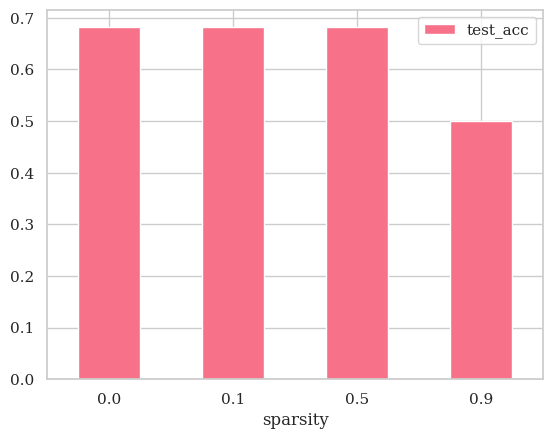

In [64]:
results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)

In [ ]:
# Pruning [0, 0.1, 0.5, 0.9]
# 1. Load the best model
# 2. Loop through its layers
# 3. At each layer, set a random % of weights to zero (% sparsity)
# 4. Test